In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

nlp = spacy.load('en')
%matplotlib inline

In [2]:
df = pd.read_json('reviews.json')
df.head()

,Date,Image,Review,Star,Status,Subject,author
0,2017-03-04,1,These Rockbirds LED Flashlights I bought came ...,5.0 out of 5 stars,Verified Purchase,Quality made and a fantastic deal! Let me sho...,GardenGuy
1,2018-02-10,0,"Given my many prior, poor experiences with sev...",4.0 out of 5 stars,Verified Purchase,"Miniature in size & price, but big on light ou...",NSB
10,2017-04-30,0,"Really love these little flashlights, they're ...",4.0 out of 5 stars,Verified Purchase,"Fantastic Little Flashlight, Except...",The Great Buzzwami
100,2017-06-27,0,little rust inside and poor quality,1.0 out of 5 stars,Verified Purchase,One Star,Joe
1000,2018-04-09,0,Great little bright light!,5.0 out of 5 stars,Verified Purchase,Five Stars,Laura


In [3]:
#extract star
df['Star'] = df['Star'].apply(lambda x: x.split(' ')[0])
#since every row represents a verified purchase just drop the column
df.drop('Status',inplace=True,axis=1)
#convert Star to numeric 
df.Star = pd.to_numeric(df.Star)
#convert Data to datetime and pick data after January 1st, 2017
df.Date = pd.to_datetime(df.Date)
df= df[df['Date'] > '2017-01-01']
#Extract the month of the reviews
df['month'] = pd.to_datetime(df.Date).dt.month
#Extract the day of the reviews
df['day'] = pd.to_datetime(df.Date).dt.day
df = df.reset_index(drop=True)

## Star distribution
- The mean star of all reviews are 4.2

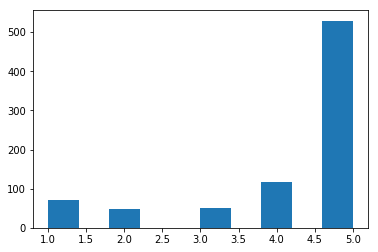

In [4]:
plt.hist(df.Star)
plt.show()

In [5]:
df.Star.describe()

count    813.000000
mean       4.211562
std        1.298735
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: Star, dtype: float64

## Average stars per month
- the plot of mean star for every month shows that the month may influence the star reviews made

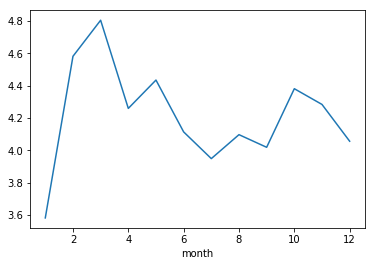

In [6]:
df.groupby(['month']).Star.mean().plot(kind='line')

### Let's count the number of reviews each reviewers made
- Chris and Eric made 4 reviews and there are names like CJ and B which seems like a nickname let's check their reviews

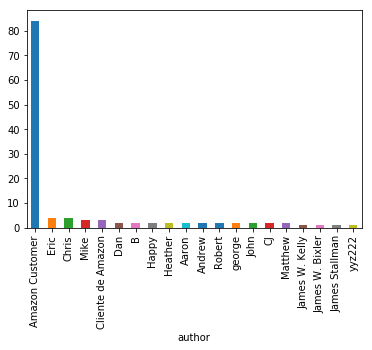

In [7]:
df.groupby(['author']).Star.count().sort_values(ascending=False)[:20].plot(kind='bar')

In [8]:
df[df['author'].isin(['Chris','Eric','CJ'])]

,Date,Image,Review,Star,Subject,author,month,day
24,2017-09-21,0,Very bright and compact,5.0,Works great,Eric,9,21
105,2017-12-31,0,"These are good to have everywhere, especially ...",5.0,Handy with the clip on side,CJ,12,31
218,2017-09-13,0,Bought before hurricane Irma. Wanted led flash...,5.0,Bought before hurricane Irma. Wanted led flash...,CJ,9,13
365,2017-09-19,0,works good. Love that it takes 1 AA and its p...,5.0,Pretty good.,Eric,9,19
371,2018-03-04,0,Very bright flashlight. Used at the beach wal...,5.0,Good flashlights for the price,Eric,3,4
389,2017-04-12,0,"Pretty Good, Not as expected for any pinpoint ...",4.0,"Pretty Good, Not as expected for any pinpoint ...",Eric,4,12
391,2017-08-29,0,These are amazingly good little flashlights. ...,5.0,Five Stars,Chris,8,29
422,2018-02-13,0,Small and powerful!,5.0,Five Stars,Chris,2,13
607,2017-06-27,0,"Just received these today. So far so good, not...",2.0,"So far so good, not super bright but not bad e...",Chris,6,27
665,2017-05-10,1,I got the 4 pack camping lights the other day....,5.0,"lightweight,good for group camping",Chris,5,10


 Seems everything goes well so we can't get much information from Author of the review

In [9]:
df.drop(['author','Date','day'],inplace=True,axis=1)

###  Let's see if the length of the review will reflect the reviewer's attitute toward the item

In [10]:
df['Length_of_Review'] = df.Review.apply(lambda x: len(x))

In [11]:
df['Length_cat'] = np.ceil(df['Length_of_Review']/200)

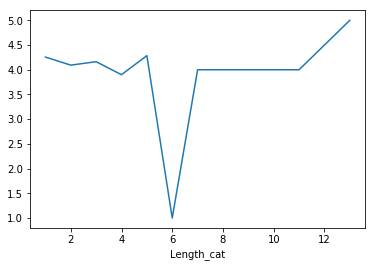

In [12]:
df.groupby('Length_cat').Star.mean().plot(kind='line')

In [13]:
df['Length_cat'].value_counts()

1.0     600
2.0     139
3.0      43
4.0      20
5.0       7
13.0      1
7.0       1
6.0       1
11.0      1
Name: Length_cat, dtype: int64

In [14]:
np.corrcoef([df['Length_cat'],df['Star']])

array([[ 1.        , -0.04624103],
       [-0.04624103,  1.        ]])

### seems the length of the review does not correlate to the star, the gap in 6 of the Length_cat is because of the one single review so it's not representative.

In [15]:
df.drop(['Length_of_Review'],axis=1,inplace=True)

## Sentiment Analysis
- here we use nltk to process sentiment analysis to see if we can extract information from review's sentiment

In [16]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
ss = sid.polarity_scores(df.Review[0])

C:\Users\lin\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [17]:
compound=[]
neg=[]
neu=[]
pos=[]
for i in range(len(df)):
    ss = sid.polarity_scores(df.Review[i])
    compound.append(ss['compound'])
    neg.append(ss['neg'])
    neu.append(ss['neu'])
    pos.append(ss['pos'])
df['Review_compund']=compound
df['Review_neg']=neg
df['Review_neu']=neu
df['Review_pos']=pos

In [18]:
compound=[]
neg=[]
neu=[]
pos=[]
for i in range(len(df)):
    ss = sid.polarity_scores(df.Subject[i])
    compound.append(ss['compound'])
    neg.append(ss['neg'])
    neu.append(ss['neu'])
    pos.append(ss['pos'])
df['Subject_compund']=compound
df['Subject_neg']=neg
df['Subject_neu']=neu
df['Subject_pos']=pos

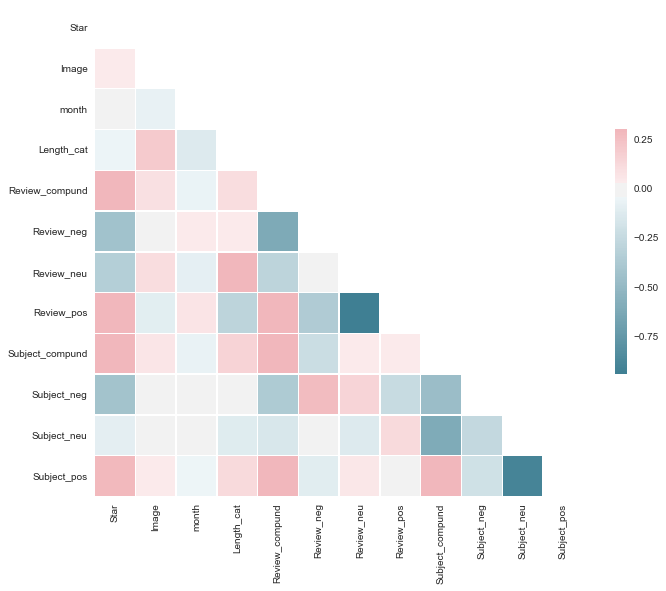

In [19]:
corr = df[['Star','Image','month', 'Length_cat',
       'Review_compund', 'Review_neg', 'Review_neu', 'Review_pos',
       'Subject_compund', 'Subject_neg', 'Subject_neu', 'Subject_pos']].corr()
sns.set(style="white")
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)


sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Correlation Heatmap
- from correlation heatmap we can see that review and subjects' sentiment will reflect the Star customer made

## vectorize our reviews and subject
- but first we want to lemmatize our sentence

In [20]:
def lemmatize(sentence):    
    doc = nlp(sentence)    
    preprocessed_sentences  = ' '.join([t.lemma_ for t in doc])
    preprocessed_sentences = preprocessed_sentences.replace('-PRON-' , '')
    preprocessed_sentences = preprocessed_sentences.replace('-pron-' , '')
    return preprocessed_sentences 

In [21]:
df.Review = df.Review.apply(lemmatize)
df.Subject = df.Subject.apply(lemmatize)

### Now we can use TF-IDF algorithm to vectorize our reviews and subject

In [22]:
class Vectorizer(BaseEstimator, TransformerMixin):
    def __init__(self,max_df=1,min_df=0,ngram_range=(1,2)):
        self.max_df = max_df
        self.min_df = min_df
        self.ngram_range =ngram_range
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        vectorizer = TfidfVectorizer(ngram_range=self.ngram_range,stop_words='english',max_df=self.max_df,min_df=self.min_df)
        review_vector = vectorizer.fit_transform(X['Review'])
        subject_vector = vectorizer.fit_transform(X['Subject'])
        vec_df = pd.concat([pd.DataFrame(review_vector.toarray()),pd.DataFrame(subject_vector.toarray())],axis=1)
        vec_df = pd.concat([vec_df,df.drop(['Review','Subject'],axis=1)],axis=1)
        vec_df = vec_df.fillna(0)
    
        return vec_df

In [23]:
label = df.Star
data= df.drop('Star',axis=1)

### Let's train our model

In [24]:
vec = Vectorizer()
pre_process_data = vec.fit_transform(data)
#first vectorize our review and subject
rf = RandomForestClassifier()
cross_val_score(rf, X=pre_process_data, y=label, cv=10,scoring='accuracy').mean()

0.84660576717352742

### Using RandomForestClassifier the mean accuracy of 10 fold cross validation is 85.13%

### Data Augmentation
Since it's an unbalanced dataset we can use RandomOverSampler to generate new samples in the classes which are under-represented

In [25]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(pre_process_data, label)
cross_val_score(rf, X=X_resampled, y=y_resampled, cv=10).mean()


0.99735123367198852

#### after data augmentation the mean accuracy of 10 fold cross validation is 99.77%